# Simple market momentum predictor
this code is intended as an example of using random forrests to generate a thesis on tomorrows market direction

first, this is not backtested and optimized and shouldn't be used for financial decisions

the problem is reduced to something of a weather prediction. 
given what i know about yesterdays weather (or recent weather), what is my expectation for tomorrow.
here i will re-iterate that this is not intended to use for financial decisions.

key components of such a prediction should rely on some market representation of volatility (vix in this case), complementary index activity (correlated), and the (in this case unweighted) market sectors of the index (loosely finance XLF, technology XLK, energy XLE etc).
we also include TLT as the bond market absolutely influences equities.

In [97]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


In [98]:
# grabbing data from the yahoo finance api
stock = yf.download(
    tickers='SPY XLF XLK XLE XLB QQQ TLT',
    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    period="5y",
    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval="1d",
    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',
    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust=True,
    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,
    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=True
)
stock = stock.dropna()


[*********************100%***********************]  7 of 7 completed


In [131]:
# calculate a few common moving averages, we will make use of these to some degree later
dma = pd.DataFrame()
dma['10dma'] = stock['SPY', 'Close'].rolling(window=10, center=False).mean()
dma['20dma'] = stock['SPY', 'Close'].rolling(window=20, center=False).mean()
dma['50dma'] = stock['SPY', 'Close'].rolling(window=50, center=False).mean()
dma['100dma'] = stock['SPY', 'Close'].rolling(window=100, center=False).mean()
dma['200dma'] = stock['SPY', 'Close'].rolling(window=200, center=False).mean()

dma['e10dma'] = stock['SPY', 'Close'].ewm(
    halflife='10 days', times=pd.DatetimeIndex(dma.index.values)).mean()
dma['e20dma'] = stock['SPY', 'Close'].ewm(
    halflife='20 days', times=pd.DatetimeIndex(dma.index.values)).mean()
dma['e50dma'] = stock['SPY', 'Close'].ewm(
    halflife='50 days', times=pd.DatetimeIndex(dma.index.values)).mean()
dma['e100dma'] = stock['SPY', 'Close'].ewm(
    halflife='100 days', times=pd.DatetimeIndex(dma.index.values)).mean()
dma['e200dma'] = stock['SPY', 'Close'].ewm(
    halflife='200 days', times=pd.DatetimeIndex(dma.index.values)).mean()


Mean Absolute Error: 1.39 dollars.
Accuracy: 99.56 %.


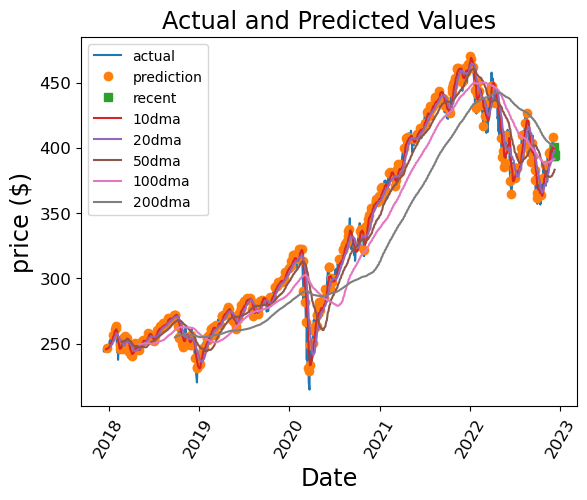

In [103]:
# initiating arrays for labels
labels = np.array(stock.SPY.Close[1:])
# can't use the data set we're training against in the predictors
features = stock.drop(('SPY', 'Close'), axis=1)[1:]
# grabbing headers of residual columns
feature_list = list(features.columns)

# splits the train and test sets
# this is just an example and the split is *not optimized* for correct sampling
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=42)

# Instantiate model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

# make a prediction
predictions = rf.predict(test_features)

# calculate mae
# there may be other, better loss functions
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2))
                       for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(
    feature_importances, key=lambda x: x[1], reverse=True)

# Print out the feature and importances
# TODO passing tuple to string is bad - fix
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


# recent date predictions
recent_predictions = rf.predict(stock.tail().drop(('SPY', 'Close'), axis=1))
df = stock.tail().copy()
df['predicted'] = recent_predictions

stock['diff'] = np.gradient(stock[('SPY', 'Close')])

# plotting predictions vs actuals
# this gives us some intuition on if we are directionally correct and accurate
predictions_data = pd.DataFrame(
    {'date': test_features.index, 'prediction': predictions})

recent_predictions_data = pd.DataFrame(
    {'date': df.index, 'prediction': recent_predictions})

actual_data = pd.DataFrame({'date': stock.index[1:], 'actuals': labels})

plt.plot(actual_data['date'], actual_data['actuals'], label='actual')

plt.plot(predictions_data['date'], predictions_data['prediction'],
         marker='o', linestyle='', label='prediction')

plt.plot(recent_predictions_data.date, recent_predictions_data.prediction,
         label='recent', linestyle='', marker='s')

plt.plot(dma['10dma'], label='10dma')
plt.plot(dma['20dma'], label='20dma')
plt.plot(dma['50dma'], label='50dma')
plt.plot(dma['100dma'], label='100dma')
plt.plot(dma['200dma'], label='200dma')

plt.xticks(rotation='60')
plt.legend()

plt.xlabel('Date', fontsize='xx-large')
plt.ylabel('price ($)', fontsize='xx-large')
plt.title('Actual and Predicted Values', fontsize='xx-large')
plt.tick_params('both', labelsize='large')
plt.show()


In [105]:
labels = np.array(stock.SPY.Close[1:])
features = stock['SPY'].drop('Close', axis=1)[1:]
feature_list = list(stock.columns)
feature_list.remove(('SPY', 'Close'))


In [106]:
features = stock.drop(('SPY', 'Close'), axis=1)[1:]


In [107]:
df


QQQ                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2022-12-05  290.380005  291.679993  286.149994  287.640015  41482100   
2022-12-06  287.480011  287.619995  280.260010  281.679993  53937600   
2022-12-07  280.470001  282.570007  278.779999  280.529999  45614300   
2022-12-08  281.910004  284.839996  279.790009  283.850006  42594900   
2022-12-09  282.809998  285.640015  281.589996  282.040009  47798200   

                   XLK                                               ...  \
                  Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2022-12-05  134.320007  135.070007  132.229996  133.110001  5763100  ...   
2022-12-06  132.970001  133.169998  129.419998  130.259995  5899600  ...   
2022-12-07  129.789993  130.600006  128.669998  129.600006  5206900  ...   
2022-12-08  130.320007  132.100006  129.539993  131.720001  4482900  ...   
2022-12-09  131.130005  132.750000  130.419998  130.910004  5201400  ...   

                  XLF                              SPY              \
                  Low      Close    Volume        Open        High   
Date                                                                 
2022-12-05  34.849998  35.040001  53402000  403.950012  404.929993   
2022-12-06  34.450001  34.730000  45102200  399.420013  399.989990   
2022-12-07  34.509998  34.590000  37775900  392.940002  395.640015   
2022-12-08  34.500000  34.619999  46600900  395.140015  397.359985   
2022-12-09  34.480000  34.529999  40871500  394.940002  397.619995   

                                                  diff   predicted  
                   Low       Close    Volume                        
Date                                                                
2022-12-05  398.170013  399.589996  77289800 -6.540009  400.402396  
2022-12-06  391.640015  393.829987  77972200 -3.214996  393.894554  
2022-12-07  391.970001  393.160004  65927900  1.205002  393.942403  
2022-12-08  393.269989  396.239990  60737900  0.059998  395.873045  
2022-12-09  393.149994  393.279999  81367500 -2.959991  394.227411  

[5 rows x 37 columns]

In [108]:
labels_close = np.array(stock[('SPY', 'Close')])
labels_open = np.array(stock[('SPY', 'Open')])
labels_low = np.array(stock[('SPY', 'Low')])
labels_high = np.array(stock[('SPY', 'High')])
features = stock[1:stock.__len__()-1]
feature_list = list(features.columns)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels_close[2:], test_size=0.2,
                                                                            random_state=42)

# Instantiate model
rf_close = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on training data
rf_close.fit(train_features, train_labels)

predictions_close = rf_close.predict(test_features)

errors = abs(predictions_close - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'dollars.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# recent date predictions
recent_close_predictions = rf_close.predict(stock.tail())
df = stock.tail().copy()
df['tom close'] = recent_close_predictions
df['diff pred'] = recent_close_predictions - df[('SPY', 'Close')]


predictions_data = pd.DataFrame(
    {'prediction': predictions_close}, index=test_features.index)
predictions_data.sort_index(inplace=True)

# indices = stock.index.get_loc(predictions_data.index.to_list())

actual_slice = stock.shift(1).loc[stock.index.isin(test_features.index)]


Mean Absolute Error: 2.31 dollars.
Accuracy: 99.28 %.


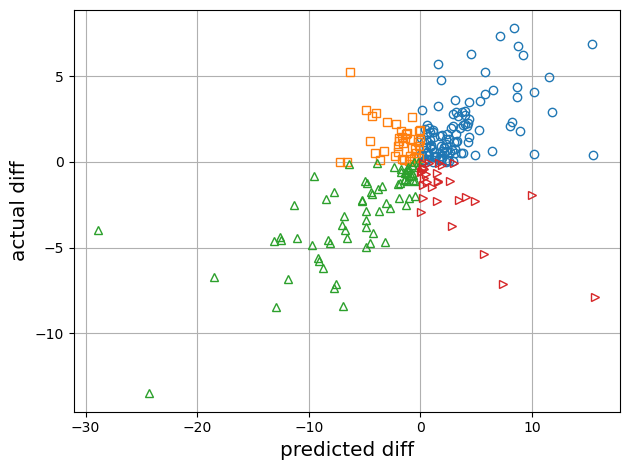

In [152]:
# here we bin by directional accuracy (pred up and we go up, down we go down)
# also highlight counter behavior (pred up we go down, pred down we go up)
x_temp = predictions_data['prediction']-actual_slice[('SPY', 'Close')]
upper_right = pd.DataFrame({'x1':x_temp>=0, 'x2':actual_slice['diff']>=0}).all(axis='columns')
upper_left = pd.DataFrame({'x1':x_temp<0, 'x2':actual_slice['diff']>=0}).all(axis='columns')
lower_left = pd.DataFrame({'x1':x_temp<0, 'x2':actual_slice['diff']<0}).all(axis='columns')
lower_right = pd.DataFrame({'x1':x_temp>=0, 'x2':actual_slice['diff']<0}).all(axis='columns')

plt.plot(
    x_temp.loc[upper_right],
    actual_slice['diff'].loc[upper_right],
    marker='o',
    linestyle='',
    mew=1,
    mfc='None',
)

plt.plot(
    x_temp.loc[upper_left],
    actual_slice['diff'].loc[upper_left],
    marker='s',
    linestyle='',
    mew=1,
    mfc='None'
)

plt.plot(
    x_temp.loc[lower_left],
    actual_slice['diff'].loc[lower_left],
    marker='^',
    linestyle='',
    mew=1,
    mfc='None'
)

plt.plot(
    x_temp.loc[lower_right],
    actual_slice['diff'].loc[lower_right],
    marker='>',
    linestyle='',
    mew=1,
    mfc='None'
)

plt.ylabel('actual diff', fontsize='x-large')
plt.xlabel('predicted diff', fontsize='x-large')

# plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()


In [164]:
# win rate stats regardless of win size 
# this is *not* expected value
omega = x_temp.__len__()
straight_wins = upper_right[upper_right == True].__len__() + lower_left[lower_left == True].__len__()
print('observed straight wins were {:.02g}'.format(straight_wins/omega))

observed straight wins were 0.73


here we have a number of comments. 
the frequency of directionally correct predictions is much higher than 50%.
we do not consider the size of the win only that if one had opened a directional position at close and held until the following days close, 73% of entries the price would have moved favorably. 
there is no consideration of draw down or profit taking, real optimization here would look at other factors to optimize for EV and profit.

In [113]:
df


QQQ                                                \
                  Open        High         Low       Close    Volume   
Date                                                                   
2022-12-05  290.380005  291.679993  286.149994  287.640015  41482100   
2022-12-06  287.480011  287.619995  280.260010  281.679993  53937600   
2022-12-07  280.470001  282.570007  278.779999  280.529999  45614300   
2022-12-08  281.910004  284.839996  279.790009  283.850006  42594900   
2022-12-09  282.809998  285.640015  281.589996  282.040009  47798200   

                   XLK                                               ...  \
                  Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2022-12-05  134.320007  135.070007  132.229996  133.110001  5763100  ...   
2022-12-06  132.970001  133.169998  129.419998  130.259995  5899600  ...   
2022-12-07  129.789993  130.600006  128.669998  129.600006  5206900  ...   
2022-12-08  130.320007  132.100006  129.539993  131.720001  4482900  ...   
2022-12-09  131.130005  132.750000  130.419998  130.910004  5201400  ...   

                  XLF                   SPY                          \
                Close    Volume        Open        High         Low   
Date                                                                  
2022-12-05  35.040001  53402000  403.950012  404.929993  398.170013   
2022-12-06  34.730000  45102200  399.420013  399.989990  391.640015   
2022-12-07  34.590000  37775900  392.940002  395.640015  391.970001   
2022-12-08  34.619999  46600900  395.140015  397.359985  393.269989   
2022-12-09  34.529999  40871500  394.940002  397.619995  393.149994   

                                      diff   tom close diff pred  
                 Close    Volume                                  
Date                                                              
2022-12-05  399.589996  77289800 -6.540009  395.045102 -4.544894  
2022-12-06  393.829987  77972200 -3.214996  393.301278 -0.528709  
2022-12-07  393.160004  65927900  1.205002  396.526880  3.366876  
2022-12-08  396.239990  60737900  0.059998  394.696922 -1.543069  
2022-12-09  393.279999  81367500 -2.959991  394.081652  0.801653  

[5 rows x 38 columns]

In [114]:
x = df['diff pred'][-2]/df['SPY', 'Close'][-2]*100
y = df['diff pred'][-1]/df['SPY', 'Close'][-2]*100

print(df.index[-2].month, df.index[-2].day,
      f'{x*.66:.2f}%', f'{x:.2f}%', f'{x*1.33:.2f}%')
print(df.index[-1].month, df.index[-1].day,
      f'{y*.66:.2f}%', f'{y:.2f}%', f'{y*1.33:.2f}%')


12 8 -0.26% -0.39% -0.52%
12 9 0.13% 0.20% 0.27%


In [117]:
# saving the model object
with open('price_model.pkl', 'wb') as fn:
    pickle.dump(rf_close, fn)


In [118]:
# utility if we want to use a previously saved model
with open('price_model.pkl', 'rb') as new_fn:
    a_new_object = pickle.load(new_fn)


In [119]:
# recent date predictions
recent_close_predictions = a_new_object.predict(stock.tail())


In [120]:
recent_close_predictions


array([395.04510214, 393.30127786, 396.52687997, 394.69692157,
       394.08165161])

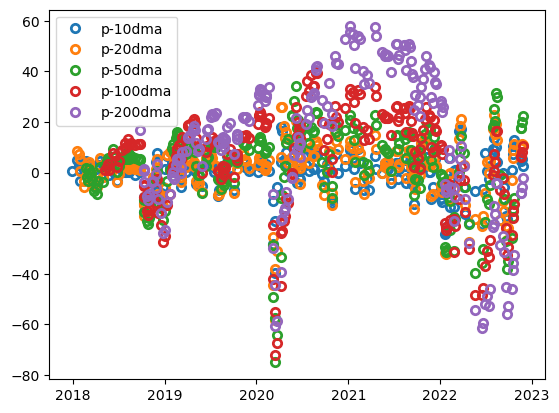

In [121]:
# TODO work on predictions vs moving average behavior
# specifically what is the responsiveness of the ML approach vs simple daily moving averages
plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['10dma'][dma['10dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-10dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['20dma'][dma['20dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-20dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['50dma'][dma['50dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-50dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['100dma'][dma['100dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-100dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['200dma'][dma['200dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-200dma'
)

plt.legend()


one way to interpret the above plot is that the simple daily moving averages are slow relative to market impulse behavior. 
you could take the specific examples of late 2018, march 2020, and well all of 2022 as key examples.
marked and sudden change in market trajectory is lost in moving averages. 
deviation from average price over some period can remain divergent for extended periods of time.
the saying 'the market can stay irrational longer than you can stay solvent' seems to apply well with these observations.

further, this seems to highlight a need, from a predictive and expectations point of view, for an impulse aware type of model

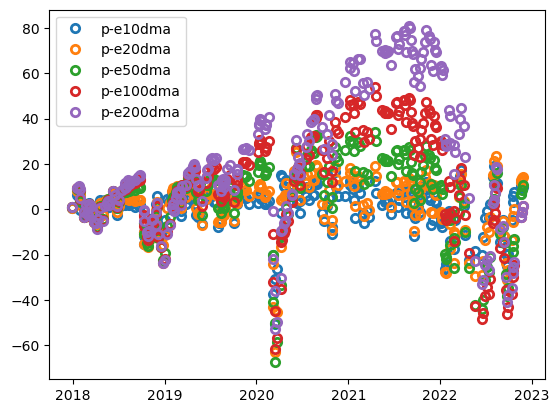

In [135]:
# TODO work on predictions vs moving average behavior
# specifically what is the responsiveness of the ML approach vs simple daily moving averages
plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['e10dma'][dma['e10dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-e10dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['e20dma'][dma['e20dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-e20dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['e50dma'][dma['e50dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-e50dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['e100dma'][dma['e100dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-e100dma'
)

plt.plot(
    predictions_data.index.values,
    predictions_data['prediction'].subtract(
        dma['e200dma'][dma['e200dma'].index.isin(predictions_data.index.array)]),
    marker='o',
    mew=2,
    mfc='None',
    ls='',
    label='p-e200dma'
)

plt.legend()


similar comments regarding the exponential moving average. 
fact seems to be that past behavior, lacking some other correlation, is not a good predictor of market behavior. 
maybe that should have been obvious.

In [ ]:
# TODO look at accuracy given VWAP for open / gaps
